## Estimating lifespan normative models

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
os.chdir('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/scripts/')

In [3]:
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d

In [4]:
os.chdir('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/')

In [196]:
# where the raw data are stored
#data_dir = '<path-to-your>/data'
data_dir = '/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/'

# where the analysis takes place
root_dir = os.path.join(data_dir,'braincharts')

#out_dir = os.path.join(root_dir,'models','hcp_race_not_modeled_asiantest') # full model used for transfering
#out_dir = os.path.join(root_dir,'models','hcp_race_not_modeled_blacktest') # full model used for transfering
#out_dir = os.path.join(root_dir,'models','hcp_race_not_modeled_whitetest') # full model used for transfering
#out_dir = os.path.join(root_dir,'models','hcp_race_modeled_asiantest') # full model used for transfering
#out_dir = os.path.join(root_dir,'models','hcp_race_modeled_blacktest') # full model used for transfering
out_dir = os.path.join(root_dir,'models','hcp_race_modeled_whitetest') # full model used for transfering

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

Now we load the data. We will load one pandas dataframe for the training set and one dataframe for the test set. We also configrure a list of site ids.

In [197]:
os.chdir(data_dir)

In [198]:
df_tr = pd.read_csv('/Users/saigerutherford/Documents/Work/eLife/lifespan_big_controls_resample_0_tr.csv', low_memory=False)

In [199]:
df_te = pd.read_csv('/Users/saigerutherford/Documents/Work/eLife/lifespan_big_controls_resample_0_te.csv', low_memory=False)

In [200]:
df = pd.merge(df_tr, df_te, how='outer')

In [201]:
df_hcp = df.query('site == "hcp_ya"')

In [ ]:
df_hcp.rename(columns={'Unnamed: 0':'sub_id'}, inplace=True)

In [203]:
demos_hcp1 = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/HCPphenotypicfactors.csv')

In [204]:
demos_hcp2 = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/hcp_income_edu.csv', sep=';')

In [205]:
demos_hcp = pd.merge(demos_hcp1, demos_hcp2, how='inner')

In [206]:
hcp_drop = ['Am. Indian/Alaskan Nat.', 'Unknown or Not Reported', 'More than one']

In [207]:
demos_hcp = demos_hcp[~demos_hcp.Race.isin(hcp_drop)]

In [208]:
demos_hcp['Race'].replace('Black or African Am.','Black',inplace=True)

In [209]:
demos_hcp['Race'].replace('Asian/Nat. Hawaiian/Othr Pacific Is.','Asian',inplace=True)

In [210]:
hcp = pd.merge(demos_hcp, df_hcp, how='inner')

In [211]:
hcp['Race2'] = hcp['Race']

In [212]:
hcp = pd.get_dummies(hcp, columns=['Race'])

In [213]:
hcp['Race2'].value_counts()

White    830
Black    168
Asian     65
Name: Race2, dtype: int64

In [214]:
df_w = hcp[hcp['Race2'] == 'White']

In [215]:
df_black = hcp[hcp['Race2'] == 'Black']

In [216]:
df_asian = hcp[hcp['Race2'] == 'Asian']

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
df_tr_w, df_te_w, y_tr_w, y_te_w = train_test_split(df_w, df_w, test_size=0.2, random_state=42,)

In [219]:
df_tr_a, df_te_a, y_tr_a, y_te_a = train_test_split(df_asian, df_asian, test_size=0.8, random_state=42,)

In [220]:
df_tr_b, df_te_b, y_tr_b, y_te_b = train_test_split(df_black, df_black, test_size=0.8, random_state=42,)

In [221]:
df_tr_wb = pd.merge(df_tr_w, df_tr_b, how='outer')

In [222]:
df_tr = pd.merge(df_tr_wb, df_tr_a, how='outer')

In [223]:
df_tr['Race2'].value_counts()

White    664
Black     33
Asian     13
Name: Race2, dtype: int64

In [110]:
df_te_wb = pd.merge(df_te_w, df_te_b, how='outer')

In [111]:
df_te = pd.merge(df_te_wb, df_te_a, how='outer')

In [224]:
#df_te = df_te_a
#df_te = df_te_b
df_te = df_te_w

In [151]:
df_te['Race2'].value_counts() / 353 * 100

White    47.025496
Black    38.243626
Asian    14.730878
Name: Race2, dtype: float64

In [152]:
df_te['sex'].value_counts() / 353 * 100

0.0    55.524079
1.0    44.475921
Name: sex, dtype: float64

In [153]:
df_te['age'].describe()

count    353.000000
mean      28.586402
std        3.978499
min       22.000000
25%       25.000000
50%       28.000000
75%       32.000000
max       37.000000
Name: age, dtype: float64

In [156]:
df_tr['Race2'].value_counts() / 710 * 100

White    93.521127
Black     4.647887
Asian     1.830986
Name: Race2, dtype: float64

In [159]:
df_tr['sex'].value_counts() / 710 * 100

0.0    53.802817
1.0    46.197183
Name: sex, dtype: float64

In [158]:
df_tr['age'].describe()

count    710.000000
mean      29.036620
std        3.506401
min       22.000000
25%       27.000000
50%       29.000000
75%       32.000000
max       36.000000
Name: age, dtype: float64

In [225]:
df_tr.shape

(710, 270)

In [226]:
df_te.shape

(166, 270)

In [227]:
# extract a list of unique site ids from the training set
site_ids =  sorted(set(df_tr['site'].to_list()))

### Configure which models to fit

Next, we load the image derived phenotypes (IDPs) which we will process in this analysis. This is effectively just a list of columns in your dataframe. Here we estimate normative models for the left hemisphere, right hemisphere and cortical structures.

In [228]:
# load the idps to process
with open(os.path.join(root_dir,'docs','phenotypes_ct_lh.txt')) as f:
    idp_ids_l = f.read().splitlines()

with open(os.path.join(root_dir,'docs','phenotypes_ct_rh.txt')) as f:
    idp_ids_r = f.read().splitlines()
    
with open(os.path.join(root_dir,'docs','phenotypes_sc.txt')) as f:
    idp_ids_sc = f.read().splitlines()

#idp_ids = idp_ids_l + idp_ids_r + idp_ids_sc
idp_ids = idp_ids_l + idp_ids_r

# we could also just specify a list of IDPs
#idp_ids = ['VisualA_SensorimotorB', 'VisualA_DorsalAttnA']

### Configure model parameters

Now, we configure some parameters for the regression model we use to fit the normative model. Here we will use a 'warped' Bayesian linear regression model. To model non-Gaussianity, we select a sin arcsinh warp and to model non-linearity, we stick with the default value for the basis expansion (a cubic b-spline basis set with 5 knot points). Since we are sticking with the default value, we do not need to specify any parameters for this, but we do need to specify the limits. We choose to pad the input by a few years either side of the input range. We will also set a couple of options that control the estimation of the model

For further details about the likelihood warping approach, see [Fraza et al 2021](https://www.biorxiv.org/content/10.1101/2021.04.05.438429v1).

In [229]:
# which data columns do we wish to use as covariates? 
#cols_cov = ['age','sex']
cols_cov = ['age','sex', 'Race_Asian', 'Race_Black', 'Race_White']

# which warping function to use? We can set this to None in order to fit a vanilla Gaussian noise model
warp =  'WarpSinArcsinh'

# limits for cubic B-spline basis 
xmin = 15
xmax = 50

# Do we want to force the model to be refit every time? 
force_refit = True

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

### Fit the models

Now we fit the models. This involves looping over the IDPs we have selected. We will use a module from PCNtoolkit to set up the design matrices, containing the covariates, fixed effects for site and nonlinear basis expansion. 

In [ ]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
   
    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy()
    y_te = df_te[idp].to_numpy()
    
    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.abs(yz_tr) < outlier_thresh
    nz_te = np.abs(yz_te) < outlier_thresh
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]
    
    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt')
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
        
    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te[cols_cov].loc[nz_te], 
                                site_ids = df_te['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'
        
        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'powell', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'

### Compute error metrics

In this section we compute the following error metrics for all IDPs (all evaluated on the test set):

- Negative log likelihood (NLL)
- Explained variance (EV)
- Mean standardized log loss (MSLL)
- Bayesian information Criteria (BIC)
- Skew and Kurtosis of the Z-distribution

In [231]:
idp_ids = ['lh_G&S_frontomargin_thickness',
 'lh_G&S_occipital_inf_thickness',
 'lh_G&S_paracentral_thickness',
 'lh_G&S_subcentral_thickness',
 'lh_G&S_transv_frontopol_thickness',
 'lh_G&S_cingul-Ant_thickness',
 'lh_G&S_cingul-Mid-Ant_thickness',
 'lh_G&S_cingul-Mid-Post_thickness',
 'lh_G_cingul-Post-dorsal_thickness',
 'lh_G_cingul-Post-ventral_thickness',
 'lh_G_cuneus_thickness',
 'lh_G_front_inf-Opercular_thickness',
 'lh_G_front_inf-Orbital_thickness',
 'lh_G_front_inf-Triangul_thickness',
 'lh_G_front_middle_thickness',
 'lh_G_front_sup_thickness',
 'lh_G_Ins_lg&S_cent_ins_thickness',
 'lh_G_insular_short_thickness',
 'lh_G_occipital_middle_thickness',
 'lh_G_occipital_sup_thickness',
 'lh_G_oc-temp_lat-fusifor_thickness',
 'lh_G_oc-temp_med-Lingual_thickness',
 'lh_G_oc-temp_med-Parahip_thickness',
 'lh_G_orbital_thickness',
 'lh_G_pariet_inf-Angular_thickness',
 'lh_G_pariet_inf-Supramar_thickness',
 'lh_G_parietal_sup_thickness',
 'lh_G_postcentral_thickness',
 'lh_G_precentral_thickness',
 'lh_G_precuneus_thickness',
 'lh_G_rectus_thickness',
 'lh_G_subcallosal_thickness',
 'lh_G_temp_sup-G_T_transv_thickness',
 'lh_G_temp_sup-Lateral_thickness',
 'lh_G_temp_sup-Plan_polar_thickness',
 'lh_G_temp_sup-Plan_tempo_thickness',
 'lh_G_temporal_inf_thickness',
 'lh_G_temporal_middle_thickness',
 'lh_Lat_Fis-ant-Horizont_thickness',
 'lh_Lat_Fis-ant-Vertical_thickness',
 'lh_Lat_Fis-post_thickness',
 'lh_Pole_occipital_thickness',
 'lh_Pole_temporal_thickness',
 'lh_S_calcarine_thickness',
 'lh_S_central_thickness',
 'lh_S_cingul-Marginalis_thickness',
 'lh_S_circular_insula_ant_thickness',
 'lh_S_circular_insula_inf_thickness',
 'lh_S_circular_insula_sup_thickness',
 'lh_S_collat_transv_ant_thickness',
 'lh_S_collat_transv_post_thickness',
 'lh_S_front_inf_thickness',
 'lh_S_front_middle_thickness',
 'lh_S_front_sup_thickness',
 'lh_S_interm_prim-Jensen_thickness',
 'lh_S_intrapariet&P_trans_thickness',
 'lh_S_oc_middle&Lunatus_thickness',
 'lh_S_oc_sup&transversal_thickness',
 'lh_S_occipital_ant_thickness',
 'lh_S_oc-temp_lat_thickness',
 'lh_S_oc-temp_med&Lingual_thickness',
 'lh_S_orbital_lateral_thickness',
 'lh_S_orbital_med-olfact_thickness',
 'lh_S_orbital-H_Shaped_thickness',
 'lh_S_parieto_occipital_thickness',
 'lh_S_pericallosal_thickness',
 'lh_S_postcentral_thickness',
 'lh_S_precentral-inf-part_thickness',
 'lh_S_precentral-sup-part_thickness',
 'lh_S_suborbital_thickness',
 'lh_S_subparietal_thickness',
 'lh_S_temporal_inf_thickness',
 'lh_S_temporal_sup_thickness',
 'lh_S_temporal_transverse_thickness',
 'rh_G&S_frontomargin_thickness',
 'rh_G&S_occipital_inf_thickness',
 'rh_G&S_paracentral_thickness',
 'rh_G&S_subcentral_thickness',
 'rh_G&S_transv_frontopol_thickness',
 'rh_G&S_cingul-Ant_thickness',
 'rh_G&S_cingul-Mid-Ant_thickness',
 'rh_G&S_cingul-Mid-Post_thickness',
 'rh_G_cingul-Post-dorsal_thickness',
 'rh_G_cingul-Post-ventral_thickness',
 'rh_G_cuneus_thickness',
 'rh_G_front_inf-Opercular_thickness',
 'rh_G_front_inf-Orbital_thickness',
 'rh_G_front_inf-Triangul_thickness',
 'rh_G_front_middle_thickness',
 'rh_G_front_sup_thickness',
 'rh_G_Ins_lg&S_cent_ins_thickness',
 'rh_G_insular_short_thickness',
 'rh_G_occipital_middle_thickness',
 'rh_G_occipital_sup_thickness',
 'rh_G_oc-temp_lat-fusifor_thickness',
 'rh_G_oc-temp_med-Lingual_thickness',
 'rh_G_oc-temp_med-Parahip_thickness',
 'rh_G_orbital_thickness',
 'rh_G_pariet_inf-Angular_thickness',
 'rh_G_pariet_inf-Supramar_thickness',
 'rh_G_parietal_sup_thickness',
 'rh_G_postcentral_thickness',
 'rh_G_precentral_thickness',
 'rh_G_precuneus_thickness',
 'rh_G_rectus_thickness',
 'rh_G_subcallosal_thickness',
 'rh_G_temp_sup-G_T_transv_thickness',
 'rh_G_temp_sup-Lateral_thickness',
 'rh_G_temp_sup-Plan_polar_thickness',
 'rh_G_temp_sup-Plan_tempo_thickness',
 'rh_G_temporal_inf_thickness',
 'rh_G_temporal_middle_thickness',
 'rh_Lat_Fis-ant-Horizont_thickness',
 'rh_Lat_Fis-ant-Vertical_thickness',
 'rh_Lat_Fis-post_thickness',
 'rh_Pole_occipital_thickness',
 'rh_Pole_temporal_thickness',
 'rh_S_calcarine_thickness',
 'rh_S_central_thickness',
 'rh_S_cingul-Marginalis_thickness',
 'rh_S_circular_insula_ant_thickness',
 'rh_S_circular_insula_inf_thickness',
 'rh_S_circular_insula_sup_thickness',
 'rh_S_collat_transv_ant_thickness',
 'rh_S_collat_transv_post_thickness',
 'rh_S_front_inf_thickness',
 'rh_S_front_middle_thickness',
 'rh_S_front_sup_thickness',
 'rh_S_interm_prim-Jensen_thickness',
 'rh_S_intrapariet&P_trans_thickness',
 'rh_S_oc_middle&Lunatus_thickness',
 'rh_S_oc_sup&transversal_thickness',
 'rh_S_occipital_ant_thickness',
 'rh_S_oc-temp_lat_thickness',
 'rh_S_oc-temp_med&Lingual_thickness',
 'rh_S_orbital_lateral_thickness',
 'rh_S_orbital_med-olfact_thickness',
 'rh_S_orbital-H_Shaped_thickness',
 'rh_S_parieto_occipital_thickness',
 'rh_S_pericallosal_thickness',
 'rh_S_postcentral_thickness',
 'rh_S_precentral-inf-part_thickness',
 'rh_S_precentral-sup-part_thickness',
 'rh_S_suborbital_thickness',
 'rh_S_subparietal_thickness',
 'rh_S_temporal_inf_thickness',
 'rh_S_temporal_sup_thickness',
 'rh_S_temporal_transverse_thickness']

In [232]:
# initialise dataframe we will use to store quantitative metrics 
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]
    
display(blr_metrics)

blr_metrics.to_pickle(os.path.join(out_dir,'blr_metrics.pkl'))

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,lh_G&S_frontomargin_thickness,-348.041280,0.042397,-0.826595,-669.821499,0.214409,0.165692
1,lh_G&S_occipital_inf_thickness,-368.221236,-0.005753,-1.357547,-710.181412,0.380545,0.728132
2,lh_G&S_paracentral_thickness,-376.884294,0.003098,-2.699416,-727.507528,0.021081,-0.168588
3,lh_G&S_subcentral_thickness,-304.361544,0.037856,-2.268187,-582.462029,0.174803,-0.332657
4,lh_G&S_transv_frontopol_thickness,-199.524653,0.037331,-0.756383,-372.788246,0.095211,-0.481262
...,...,...,...,...,...,...,...
143,rh_S_suborbital_thickness,165.197197,-0.038004,-5.974160,356.655453,0.406678,-0.111881
144,rh_S_subparietal_thickness,-343.915753,-0.005383,-0.576816,-661.570445,0.056946,0.463211
145,rh_S_temporal_inf_thickness,-412.405045,0.008122,-0.462321,-798.549031,0.083652,0.737292
146,rh_S_temporal_sup_thickness,-619.441584,0.023673,-0.344835,-1212.622108,-0.244506,0.094531


In [233]:
blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))

In [123]:
for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_estimate.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_estimate.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    SE = y_te - yhat_te
    SE_file = os.path.join(idp_dir, 'se.txt')          
    np.savetxt(SE_file, SE)

In [235]:
os.chdir(out_dir)

In [126]:
! mkdir errors

In [127]:
! for i in *; do if [[ -e ${i}/se.txt ]]; then cp ${i}/se.txt errors/${i}_error.txt; fi; done

In [128]:
#se_dir = '/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled/errors/'
se_dir = '/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled/errors/'

filelist = [name for name in os.listdir(se_dir)]

In [129]:
os.chdir(se_dir)
se_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)

In [130]:
df_te.reset_index(inplace=True)

In [ ]:
se_df['sub_id'] = df_te['sub_id']

In [132]:
#se_df.to_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled/errors.csv', index=False)
se_df.to_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled/errors.csv', index=False)

In [133]:
os.chdir(out_dir)

In [134]:
! mkdir deviation_scores

In [135]:
! for i in *; do if [[ -e ${i}/Z_estimate.txt ]]; then cp ${i}/Z_estimate.txt deviation_scores/${i}_Z_estimate.txt; fi; done

In [136]:
#z_dir = '/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled' + '/deviation_scores/'
z_dir = '/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled' + '/deviation_scores/'

filelist = [name for name in os.listdir(z_dir)]

In [137]:
os.chdir(z_dir)
Z_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)

In [ ]:
Z_df['sub_id'] = df_te['sub_id']

In [ ]:
Z_df['Race'] = df_te['Race2']

In [140]:
#Z_df.to_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled/deviation_scores.csv', index=False)
Z_df.to_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled/deviation_scores.csv', index=False)

In [170]:
Z_df = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled/deviation_scores.csv')
#Z_df = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled/deviation_scores.csv')

In [171]:
Z_df = Z_df.sort_values(by=['Race'])

In [172]:
z_long = Z_df.melt(id_vars=['sub_id','Race'],
                  value_vars=['rh_G_Ins_lg&S_cent_ins_thickness_Z_estimate',
                             'rh_G&S_cingul-Mid-Post_thickness_Z_estimate',
                             'rh_G&S_subcentral_thickness_Z_estimate',
                             'lh_G_temporal_middle_thickness_Z_estimate',
                             'lh_S_temporal_transverse_thickness_Z_estimate',
                             'rh_G_subcallosal_thickness_Z_estimate',
                             'rh_S_temporal_transverse_thickness_Z_estimate',
                             'rh_G_temp_sup-Lateral_thickness_Z_estimate',
                             'rh_S_subparietal_thickness_Z_estimate',
                             'lh_Pole_temporal_thickness_Z_estimate',
                             'rh_G_precentral_thickness_Z_estimate',
                             'lh_G_oc-temp_lat-fusifor_thickness_Z_estimate',
                             'rh_S_circular_insula_inf_thickness_Z_estimate',
                             'lh_G_cingul-Post-ventral_thickness_Z_estimate',
                             'lh_G_front_inf-Triangul_thickness_Z_estimate',
                             'lh_S_cingul-Marginalis_thickness_Z_estimate',
                             'rh_Lat_Fis-ant-Vertical_thickness_Z_estimate',
                             'lh_G&S_paracentral_thickness_Z_estimate',
                             'rh_S_postcentral_thickness_Z_estimate',
                             'lh_S_circular_insula_inf_thickness_Z_estimate',
                             'rh_G_oc-temp_lat-fusifor_thickness_Z_estimate',
                             'rh_G_cingul-Post-ventral_thickness_Z_estimate',
                             'lh_G&S_transv_frontopol_thickness_Z_estimate',
                             'rh_G_temp_sup-G_T_transv_thickness_Z_estimate',
                             'rh_S_oc-temp_med&Lingual_thickness_Z_estimate',
                             'lh_Lat_Fis-post_thickness_Z_estimate',
                             'lh_S_postcentral_thickness_Z_estimate',
                             'rh_G_rectus_thickness_Z_estimate',
                             'lh_G_temp_sup-G_T_transv_thickness_Z_estimate',
                             'rh_Pole_temporal_thickness_Z_estimate',
                             'lh_S_subparietal_thickness_Z_estimate',
                             'rh_G_cingul-Post-dorsal_thickness_Z_estimate',
                             'lh_S_oc-temp_med&Lingual_thickness_Z_estimate',
                             'rh_S_interm_prim-Jensen_thickness_Z_estimate',
                             'lh_G&S_subcentral_thickness_Z_estimate',
                             'rh_S_oc_sup&transversal_thickness_Z_estimate',
                             'lh_G_subcallosal_thickness_Z_estimate',
                             'rh_S_orbital_lateral_thickness_Z_estimate',
                             'lh_G_insular_short_thickness_Z_estimate',
                             'rh_S_collat_transv_post_thickness_Z_estimate',
                             'lh_S_occipital_ant_thickness_Z_estimate',
                             'rh_S_orbital_med-olfact_thickness_Z_estimate',
                             'lh_G_front_sup_thickness_Z_estimate',
                             'lh_S_precentral-inf-part_thickness_Z_estimate',
                             'lh_G_precentral_thickness_Z_estimate',
                             'rh_G_temporal_middle_thickness_Z_estimate',
                             'lh_S_temporal_inf_thickness_Z_estimate',
                             'rh_G_parietal_sup_thickness_Z_estimate',
                             'lh_S_collat_transv_ant_thickness_Z_estimate',
                             'rh_G_front_sup_thickness_Z_estimate',
                             'rh_S_precentral-inf-part_thickness_Z_estimate',
                             'rh_G_pariet_inf-Angular_thickness_Z_estimate',
                             'lh_S_calcarine_thickness_Z_estimate',
                             'lh_S_orbital-H_Shaped_thickness_Z_estimate',
                             'rh_G_front_inf-Opercular_thickness_Z_estimate',
                             'rh_G_occipital_middle_thickness_Z_estimate',
                             'lh_G_oc-temp_med-Parahip_thickness_Z_estimate',
                             'rh_G_orbital_thickness_Z_estimate',
                             'lh_S_front_inf_thickness_Z_estimate',
                             'rh_S_calcarine_thickness_Z_estimate',
                             'rh_G_occipital_sup_thickness_Z_estimate',
                             'lh_G_front_inf-Opercular_thickness_Z_estimate',
                             'lh_G_front_middle_thickness_Z_estimate',
                             'lh_S_central_thickness_Z_estimate',
                             'rh_S_front_inf_thickness_Z_estimate',
                             'rh_G_oc-temp_med-Parahip_thickness_Z_estimate',
                             'lh_Lat_Fis-ant-Horizont_thickness_Z_estimate',
                             'rh_G_front_inf-Orbital_thickness_Z_estimate',
                             'lh_G_orbital_thickness_Z_estimate',
                             'lh_S_oc_middle&Lunatus_thickness_Z_estimate',
                             'rh_S_central_thickness_Z_estimate',
                             'lh_G_cuneus_thickness_Z_estimate',
                             'rh_G_front_middle_thickness_Z_estimate',
                             'rh_S_precentral-sup-part_thickness_Z_estimate',
                             'rh_Lat_Fis-post_thickness_Z_estimate',
                             'lh_G_temp_sup-Plan_tempo_thickness_Z_estimate',
                             'lh_G_parietal_sup_thickness_Z_estimate',
                             'rh_S_temporal_inf_thickness_Z_estimate',
                             'lh_S_circular_insula_ant_thickness_Z_estimate',
                             'lh_S_precentral-sup-part_thickness_Z_estimate',
                             'lh_S_orbital_lateral_thickness_Z_estimate',
                             'lh_S_parieto_occipital_thickness_Z_estimate',
                             'rh_G&S_cingul-Mid-Ant_thickness_Z_estimate',
                             'rh_G_temp_sup-Plan_tempo_thickness_Z_estimate',
                             'rh_S_circular_insula_ant_thickness_Z_estimate',
                             'rh_MeanThickness_thickness_Z_estimate',
                             'rh_S_orbital-H_Shaped_thickness_Z_estimate',
                             'lh_G_occipital_middle_thickness_Z_estimate',
                             'lh_S_circular_insula_sup_thickness_Z_estimate',
                             'lh_G_pariet_inf-Angular_thickness_Z_estimate',
                             'rh_G&S_paracentral_thickness_Z_estimate',
                             'lh_G_temp_sup-Plan_polar_thickness_Z_estimate',
                             'rh_S_collat_transv_ant_thickness_Z_estimate',
                             'rh_S_circular_insula_sup_thickness_Z_estimate',
                             'rh_G_temp_sup-Plan_polar_thickness_Z_estimate',
                             'rh_Pole_occipital_thickness_Z_estimate',
                             'lh_G_pariet_inf-Supramar_thickness_Z_estimate',
                             'lh_G&S_frontomargin_thickness_Z_estimate',
                             'rh_S_pericallosal_thickness_Z_estimate',
                             'rh_G_pariet_inf-Supramar_thickness_Z_estimate',
                             'rh_S_suborbital_thickness_Z_estimate',
                             'lh_S_pericallosal_thickness_Z_estimate',
                             'rh_S_occipital_ant_thickness_Z_estimate',
                             'lh_Pole_occipital_thickness_Z_estimate',
                             'rh_G_insular_short_thickness_Z_estimate',
                             'lh_G_front_inf-Orbital_thickness_Z_estimate',
                             'rh_G_cuneus_thickness_Z_estimate',
                             'rh_S_oc_middle&Lunatus_thickness_Z_estimate',
                             'lh_G&S_cingul-Mid-Ant_thickness_Z_estimate',
                             'rh_G&S_occipital_inf_thickness_Z_estimate',
                             'rh_Lat_Fis-ant-Horizont_thickness_Z_estimate',
                             'rh_S_parieto_occipital_thickness_Z_estimate',
                             'lh_MeanThickness_thickness_Z_estimate',
                             'rh_G_precuneus_thickness_Z_estimate',
                             'lh_G_temp_sup-Lateral_thickness_Z_estimate',
                             'lh_S_front_middle_thickness_Z_estimate',
                             'lh_G_Ins_lg&S_cent_ins_thickness_Z_estimate',
                             'lh_G_occipital_sup_thickness_Z_estimate',
                             'lh_G_postcentral_thickness_Z_estimate',
                             'rh_S_front_sup_thickness_Z_estimate',
                             'lh_G&S_cingul-Mid-Post_thickness_Z_estimate',
                             'lh_G_precuneus_thickness_Z_estimate',
                             'lh_G&S_cingul-Ant_thickness_Z_estimate',
                             'lh_S_front_sup_thickness_Z_estimate',
                             'lh_S_oc-temp_lat_thickness_Z_estimate',
                             'rh_G&S_frontomargin_thickness_Z_estimate',
                             'lh_Lat_Fis-ant-Vertical_thickness_Z_estimate',
                             'lh_G_temporal_inf_thickness_Z_estimate',
                             'rh_G_front_inf-Triangul_thickness_Z_estimate',
                             'lh_S_temporal_sup_thickness_Z_estimate',
                             'rh_S_cingul-Marginalis_thickness_Z_estimate',
                             'lh_G_rectus_thickness_Z_estimate',
                             'lh_S_interm_prim-Jensen_thickness_Z_estimate',
                             'lh_S_intrapariet&P_trans_thickness_Z_estimate',
                             'lh_G_cingul-Post-dorsal_thickness_Z_estimate',
                             'rh_S_intrapariet&P_trans_thickness_Z_estimate',
                             'rh_G_temporal_inf_thickness_Z_estimate',
                             'rh_G&S_transv_frontopol_thickness_Z_estimate',
                             'lh_G&S_occipital_inf_thickness_Z_estimate',
                             'rh_S_temporal_sup_thickness_Z_estimate',
                             'rh_S_oc-temp_lat_thickness_Z_estimate',
                             'rh_S_front_middle_thickness_Z_estimate',
                             'lh_S_orbital_med-olfact_thickness_Z_estimate',
                             'lh_G_oc-temp_med-Lingual_thickness_Z_estimate',
                             'lh_S_collat_transv_post_thickness_Z_estimate',
                             'lh_S_suborbital_thickness_Z_estimate',
                             'rh_G&S_cingul-Ant_thickness_Z_estimate',
                             'rh_G_postcentral_thickness_Z_estimate',
                             'rh_G_oc-temp_med-Lingual_thickness_Z_estimate',
                             'lh_S_oc_sup&transversal_thickness_Z_estimate'])

In [69]:
import pingouin as pg

/opt/anaconda3/envs/braincharts/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/anaconda3/envs/braincharts/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [70]:
import ptitprince as pt

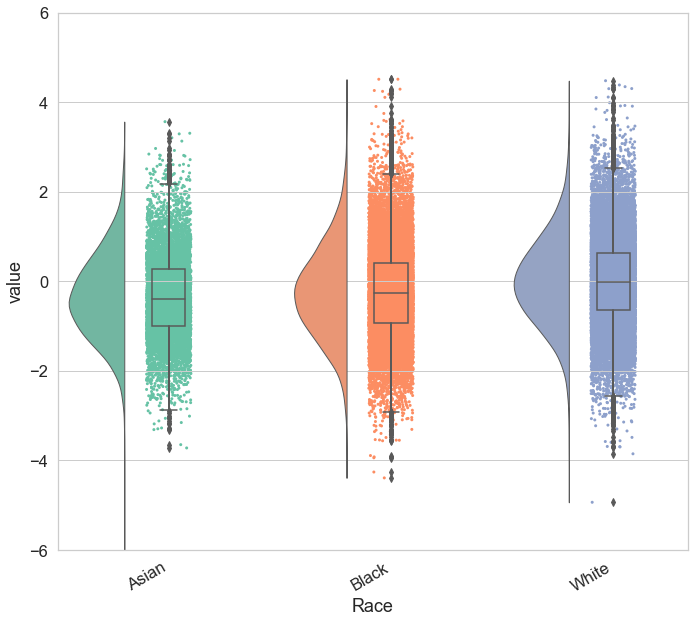

In [173]:
# Race Not Included in Model
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 9))

pt.RainCloud(x = z_long['Race'], y = z_long['value'], data = z_long, 
             ax = ax, width_viol=0.5);
ax.set_ylim(-6, 6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()

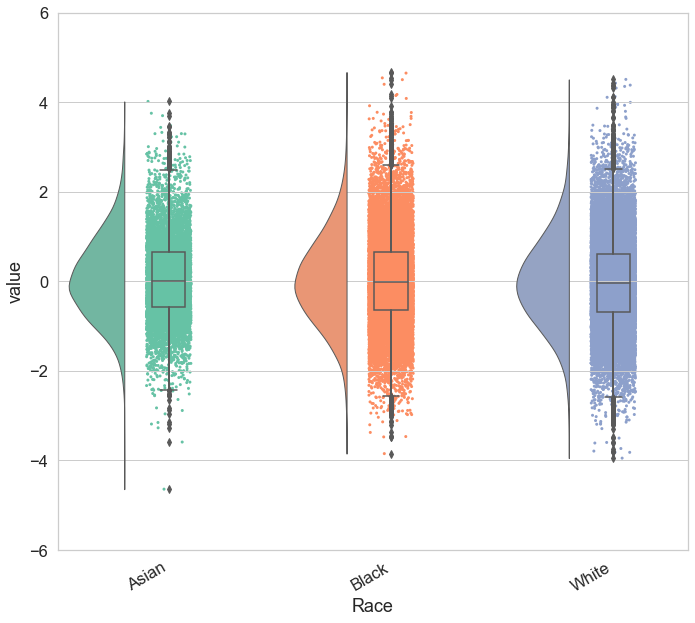

In [169]:
# Race Included in Model
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 9))

pt.RainCloud(x = z_long['Race'], y = z_long['value'], data = z_long, 
             ax = ax, width_viol=0.5);
ax.set_ylim(-6, 6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()

In [143]:
asian_z_long = z_long.query('Race == "Asian"')
black_z_long = z_long.query('Race == "Black"')
white_z_long = z_long.query('Race == "White"')

Text(0.5, 1.0, 'White')

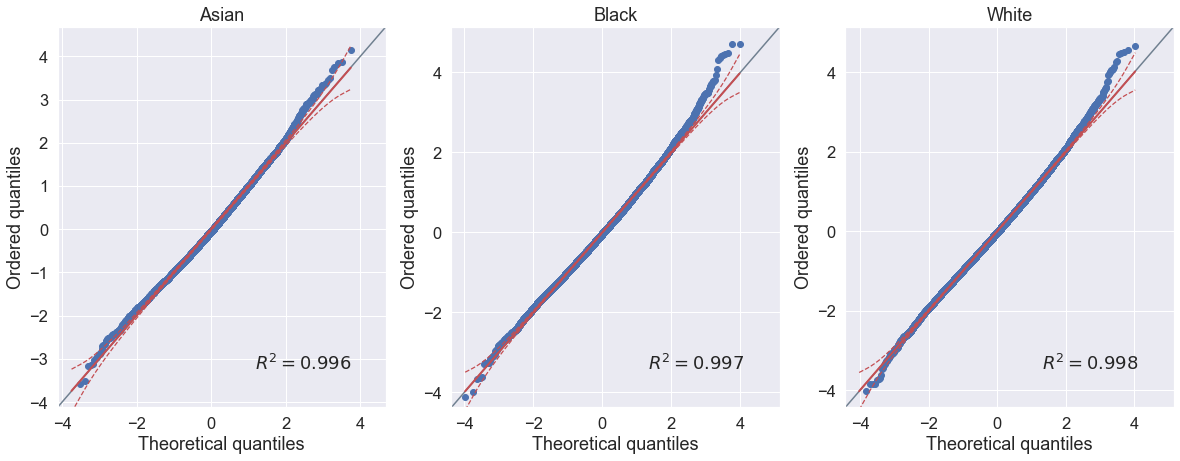

In [73]:
# Race Not Included in Model
sns.set(font_scale=1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
ax1 = pg.qqplot(asian_z_long['value'], dist='norm', ax=ax1)
ax1.set_title('Asian')
ax2 = pg.qqplot(black_z_long['value'], dist='norm', ax=ax2)
ax2.set_title('Black')
ax3 = pg.qqplot(white_z_long['value'], dist='norm', ax=ax3)
ax3.set_title('White')

Text(0.5, 1.0, 'White')

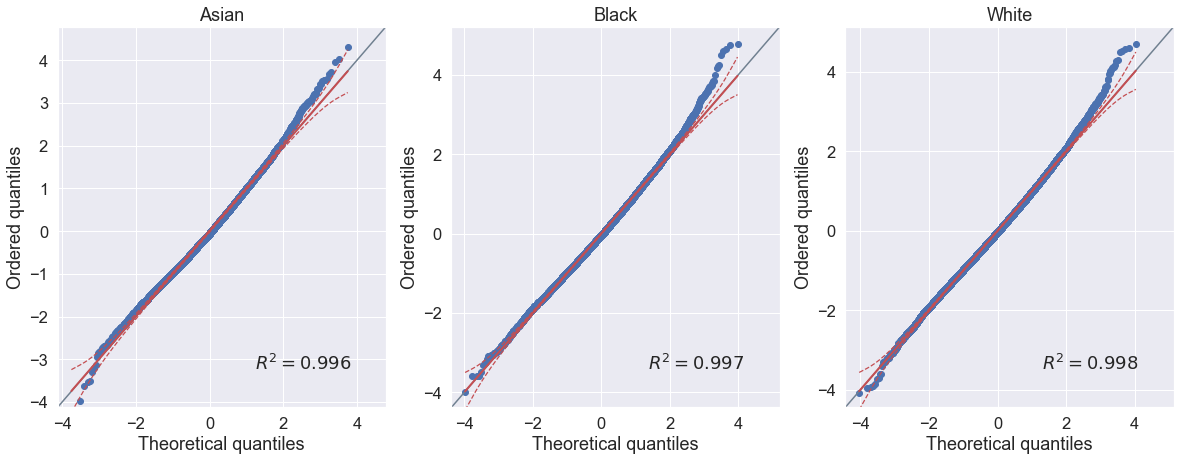

In [144]:
# Race Included in Model
sns.set(font_scale=1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
ax1 = pg.qqplot(asian_z_long['value'], dist='norm', ax=ax1)
ax1.set_title('Asian')
ax2 = pg.qqplot(black_z_long['value'], dist='norm', ax=ax2)
ax2.set_title('Black')
ax3 = pg.qqplot(white_z_long['value'], dist='norm', ax=ax3)
ax3.set_title('White')

In [145]:
#error = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled/errors.csv')
error = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled/errors.csv')

In [146]:
demos_hcp = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/demos_short_hcp.csv')

In [147]:
df_err_hcp = pd.merge(demos_hcp, error, how='inner')

In [148]:
df_err_hcp_long = df_err_hcp.melt(id_vars=['sub_id','Race', 'Dubois_Sum', 'g_efa', 'g_cfa', 'V_fac', 'GenPsychpath', 
                                           'Psychopath_Fac2', 'Subject', 'SSAGA_Employ', 'SSAGA_Income', 'SSAGA_Educ', 
                                           'SSAGA_InSchool', 'SSAGA_Rlshp', 'SSAGA_MOBorn'], 
                  value_vars=['rh_S_circular_insula_sup_thickness_error',
 'lh_G_temp_sup-Plan_tempo_thickness_error',
 'rh_G_oc-temp_med-Parahip_thickness_error',
 'lh_G_occipital_middle_thickness_error',
 'rh_G_oc-temp_med-Lingual_thickness_error',
 'lh_S_intrapariet&P_trans_thickness_error',
 'lh_G_cingul-Post-ventral_thickness_error',
 'lh_G&S_cingul-Mid-Post_thickness_error',
 'lh_Pole_temporal_thickness_error',
 'rh_G&S_frontomargin_thickness_error',
 'lh_Lat_Fis-post_thickness_error',
 'rh_G_front_middle_thickness_error',
 'rh_S_postcentral_thickness_error',
 'rh_G_precentral_thickness_error',
 'lh_G&S_frontomargin_thickness_error',
 'rh_S_temporal_inf_thickness_error',
 'rh_S_cingul-Marginalis_thickness_error',
 'rh_S_central_thickness_error',
 'lh_G_cuneus_thickness_error',
 'lh_G_insular_short_thickness_error',
 'rh_Lat_Fis-ant-Vertical_thickness_error',
 'rh_G_cingul-Post-dorsal_thickness_error',
 'lh_S_precentral-sup-part_thickness_error',
 'lh_S_cingul-Marginalis_thickness_error',
 'rh_G_front_inf-Triangul_thickness_error',
 'rh_G_front_inf-Opercular_thickness_error',
 'lh_S_temporal_inf_thickness_error',
 'rh_G&S_occipital_inf_thickness_error',
 'lh_S_orbital_lateral_thickness_error',
 'rh_G_pariet_inf-Supramar_thickness_error',
 'rh_G&S_paracentral_thickness_error',
 'lh_S_collat_transv_post_thickness_error',
 'lh_G_occipital_sup_thickness_error',
 'lh_S_calcarine_thickness_error',
 'lh_G_oc-temp_lat-fusifor_thickness_error',
 'rh_G&S_cingul-Mid-Post_thickness_error',
 'lh_S_oc-temp_lat_thickness_error',
 'lh_S_subparietal_thickness_error',
 'rh_G_occipital_middle_thickness_error',
 'rh_S_interm_prim-Jensen_thickness_error',
 'lh_G_front_middle_thickness_error',
 'lh_G_precuneus_thickness_error',
 'lh_S_oc-temp_med&Lingual_thickness_error',
 'lh_G_pariet_inf-Angular_thickness_error',
 'lh_G_precentral_thickness_error',
 'rh_S_intrapariet&P_trans_thickness_error',
 'rh_G_cingul-Post-ventral_thickness_error',
 'lh_S_orbital_med-olfact_thickness_error',
 'lh_G_postcentral_thickness_error',
 'rh_Lat_Fis-post_thickness_error',
 'lh_G_oc-temp_med-Lingual_thickness_error',
 'rh_G_temp_sup-Plan_tempo_thickness_error',
 'lh_S_circular_insula_sup_thickness_error',
 'lh_G_oc-temp_med-Parahip_thickness_error',
 'lh_G&S_transv_frontopol_thickness_error',
 'rh_S_front_sup_thickness_error',
 'lh_G_temporal_inf_thickness_error',
 'lh_G_temp_sup-Lateral_thickness_error',
 'lh_G&S_cingul-Mid-Ant_thickness_error',
 'rh_G_parietal_sup_thickness_error',
 'lh_S_orbital-H_Shaped_thickness_error',
 'lh_S_front_middle_thickness_error',
 'rh_G_front_sup_thickness_error',
 'lh_G&S_subcentral_thickness_error',
 'rh_G_orbital_thickness_error',
 'rh_G_subcallosal_thickness_error',
 'lh_S_front_inf_thickness_error',
 'lh_G_front_inf-Opercular_thickness_error',
 'rh_S_front_middle_thickness_error',
 'lh_G_parietal_sup_thickness_error',
 'rh_S_precentral-sup-part_thickness_error',
 'lh_S_oc_sup&transversal_thickness_error',
 'rh_G&S_subcentral_thickness_error',
 'rh_S_orbital-H_Shaped_thickness_error',
 'rh_G&S_cingul-Mid-Ant_thickness_error',
 'rh_G_temp_sup-Lateral_thickness_error',
 'lh_G_pariet_inf-Supramar_thickness_error',
 'rh_G_rectus_thickness_error',
 'rh_G_oc-temp_lat-fusifor_thickness_error',
 'rh_S_oc-temp_med&Lingual_thickness_error',
 'rh_G_temporal_inf_thickness_error',
 'lh_S_occipital_ant_thickness_error',
 'lh_G&S_occipital_inf_thickness_error',
 'rh_Lat_Fis-ant-Horizont_thickness_error',
 'rh_S_orbital_lateral_thickness_error',
 'lh_Lat_Fis-ant-Vertical_thickness_error',
 'lh_G_cingul-Post-dorsal_thickness_error',
 'lh_S_central_thickness_error',
 'lh_G_front_inf-Orbital_thickness_error',
 'rh_G_insular_short_thickness_error',
 'lh_S_temporal_sup_thickness_error',
 'rh_G_postcentral_thickness_error',
 'rh_G_cuneus_thickness_error',
 'lh_G_Ins_lg&S_cent_ins_thickness_error',
 'lh_G&S_cingul-Ant_thickness_error',
 'lh_S_interm_prim-Jensen_thickness_error',
 'lh_G&S_paracentral_thickness_error',
 'rh_G_temp_sup-Plan_polar_thickness_error',
 'lh_G_temp_sup-G_T_transv_thickness_error',
 'rh_G_occipital_sup_thickness_error',
 'rh_S_suborbital_thickness_error',
 'rh_G&S_cingul-Ant_thickness_error',
 'rh_S_circular_insula_ant_thickness_error',
 'lh_G_subcallosal_thickness_error',
 'lh_G_temporal_middle_thickness_error',
 'rh_S_collat_transv_post_thickness_error',
 'rh_S_circular_insula_inf_thickness_error',
 'rh_S_calcarine_thickness_error',
 'lh_S_temporal_transverse_thickness_error',
 'rh_G_front_inf-Orbital_thickness_error',
 'lh_G_front_inf-Triangul_thickness_error',
 'rh_G_precuneus_thickness_error',
 'lh_S_precentral-inf-part_thickness_error',
 'rh_S_temporal_sup_thickness_error',
 'rh_G_Ins_lg&S_cent_ins_thickness_error',
 'lh_S_postcentral_thickness_error',
 'lh_S_pericallosal_thickness_error',
 'rh_S_oc_middle&Lunatus_thickness_error',
 'rh_S_collat_transv_ant_thickness_error',
 'rh_Pole_temporal_thickness_error',
 'lh_S_front_sup_thickness_error',
 'lh_Pole_occipital_thickness_error',
 'rh_G&S_transv_frontopol_thickness_error',
 'rh_G_pariet_inf-Angular_thickness_error',
 'lh_G_front_sup_thickness_error',
 'lh_S_parieto_occipital_thickness_error',
 'rh_S_orbital_med-olfact_thickness_error',
 'lh_Lat_Fis-ant-Horizont_thickness_error',
 'rh_Pole_occipital_thickness_error',
 'rh_S_front_inf_thickness_error',
 'rh_G_temp_sup-G_T_transv_thickness_error',
 'lh_G_temp_sup-Plan_polar_thickness_error',
 'lh_G_rectus_thickness_error',
 'lh_S_circular_insula_inf_thickness_error',
 'rh_S_parieto_occipital_thickness_error',
 'rh_S_occipital_ant_thickness_error',
 'lh_S_circular_insula_ant_thickness_error',
 'lh_S_suborbital_thickness_error',
 'rh_S_oc_sup&transversal_thickness_error',
 'rh_S_temporal_transverse_thickness_error',
 'rh_S_subparietal_thickness_error',
 'lh_G_orbital_thickness_error',
 'rh_G_temporal_middle_thickness_error',
 'lh_S_collat_transv_ant_thickness_error',
 'rh_S_oc-temp_lat_thickness_error',
 'rh_S_precentral-inf-part_thickness_error',
 'lh_S_oc_middle&Lunatus_thickness_error',
 'rh_S_pericallosal_thickness_error'])

In [149]:
df_err_hcp_long = df_err_hcp_long.sort_values(by=['Race'])

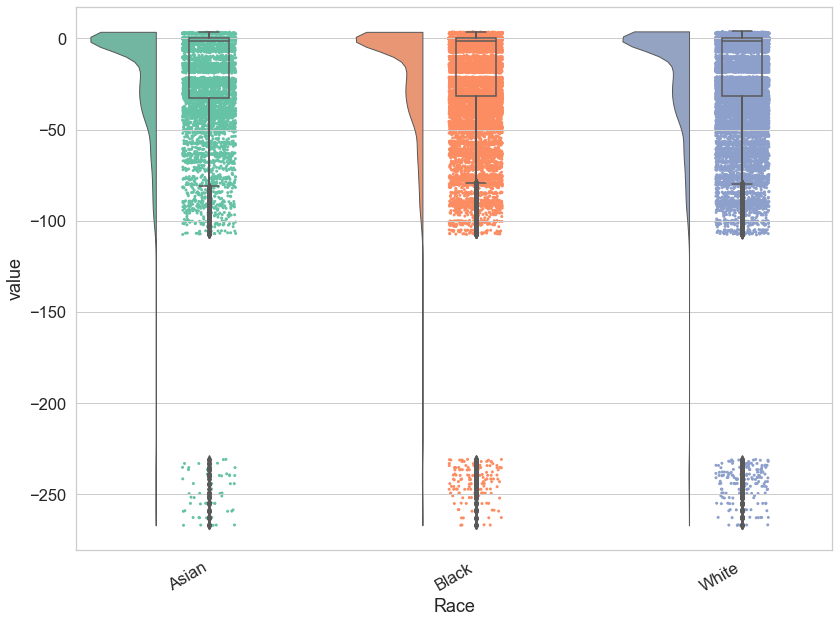

In [80]:
# Race Not Included in Model
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(12, 9))

pt.RainCloud(x = df_err_hcp_long['Race'], y = df_err_hcp_long['value'], data = df_err_hcp_long, 
             ax = ax, width_viol=0.5);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/NM_demo/hcp_ct_race.png', bbox_inches='tight')

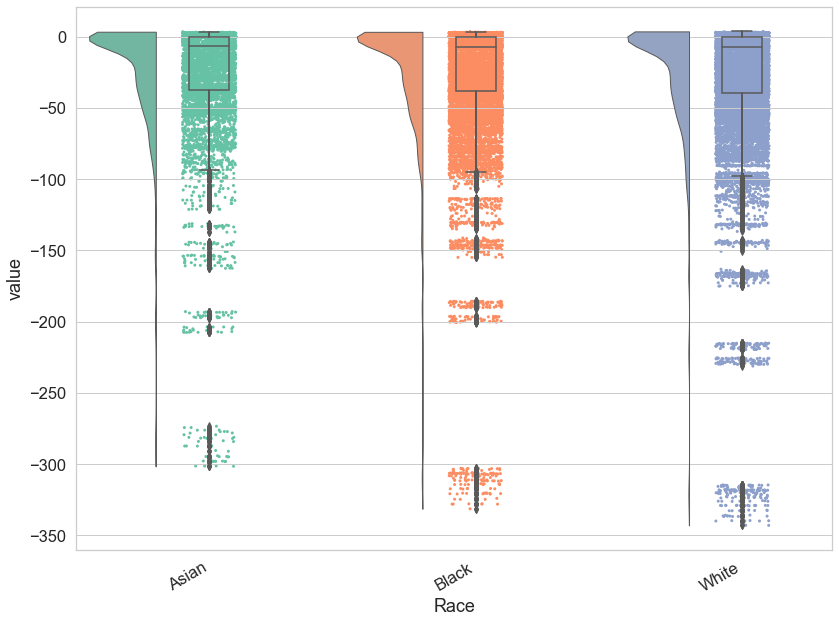

In [150]:
# Race Included in Model
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(12, 9))

pt.RainCloud(x = df_err_hcp_long['Race'], y = df_err_hcp_long['value'], data = df_err_hcp_long, 
             ax = ax, width_viol=0.5);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/NM_demo/hcp_ct_race.png', bbox_inches='tight')